# Assignment — Graph embeddings

In [31]:
from sklearn.decomposition import PCA
from scipy.sparse import csr_matrix
from tqdm.notebook import tqdm, trange
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import requests
from scipy.sparse.linalg import svds
from sklearn.cluster import k_means
from torch.optim import Adam
from sklearn.metrics import mutual_info_score
import networkx as nx
import numpy as np
from torch.utils.data import Dataset
import torch.nn as nn
from torch.utils.data import DataLoader
import torch
import random
import scipy

### Dataset

In this assignment, we will evaluate node embedding methods on the facebook graph where nodes are pages and edges are links. Each node has a category: government, tv-show, company, politician.

In [3]:
url = 'https://raw.githubusercontent.com/netspractice/network-science/main/datasets/musae_facebook_ego_802.gml'
open('musae_facebook_ego_802.gml', 'wb').write(requests.get(url).content)
G = nx.read_gml('musae_facebook_ego_802.gml')
G = nx.convert_node_labels_to_integers(G)
_labels = np.array(list(nx.get_node_attributes(G, 'value').values()))
unique = list(set(_labels))
labels = np.array([unique.index(l) for l in _labels])
len(G), labels

(3873, array([3, 3, 3, ..., 1, 1, 1]))

### Task 1. DeepWalk (0 points)

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Deepwalk is an approach for learning latent representations of nodes in a network. The motivation of DeepWalk is based on an observation that the frequency of nodes occurrence in the short random walks in social networks is similar to the frequency of words occurrence in sentences in natural languages.

<img src="https://raw.githubusercontent.com/netspractice/network-science/main/images/node_word_powerlaw.png" width=600>

The both follow a power-law distribution, therefore NLP word embedding models can help to represent nodes in networks. DeepWalk is based on SkipGram model that is trained to predict the context for a given word.

<img src='https://lena-voita.github.io/resources/lectures/word_emb/w2v/window_prob1-min.png' width=600>

(an image is taken from [NLP Course For You](https://lena-voita.github.io/nlp_course.html))

DeepWalk uses nodes instead of words and random walks on a network instead of sentences. Let a central word be a start node of a random walk, context words be nodes in a tail of a random walk.

Write a function `sample_random_walks` that takes a graph, number of walks per node and the length of walks, returns np.array of the shape (total number of walks) x (length).

In [5]:
def sample_random_walks(G, walks_per_node, length):
    walks = []
    for node in G.nodes:
        for _ in range(walks_per_node):
            walk = [node]
            random_neighbor = node
            for j in range(length-1):
                random_neighbor = np.random.choice(list(G.neighbors(random_neighbor)))
                walk.append(random_neighbor)
            walks.append(walk)
    return np.array(walks)

In [6]:
walks_per_node = 5
length = 5
rwalks = sample_random_walks(G, walks_per_node, length)
assert rwalks.shape == (len(G) * walks_per_node, length)
assert np.all(rwalks[:, 0][::5] == np.arange(len(G)))
A = nx.to_numpy_array(G)
assert np.all(A[rwalks[0, :-1], rwalks[0, 1:]] == 1)

In [7]:
rwalks

array([[   0,    8,  239,  194,  243],
       [   0,   16,  287,   17,  303],
       [   0,    8,   18,  104,   30],
       ...,
       [3872, 1980, 3178, 2116, 2121],
       [3872, 1495,  508,  316,   75],
       [3872, 1495, 1953, 2540, 1953]])

Consider a graph $G=(V,E)$. Let the first node in each random walk be _start node_ and others be _context nodes_. DeepWalk uses two embedding layers:
* $v_i: \{0, 1\}^{|V|} \to \mathbb R^{d}$ embeds the one-hot encoded vector of the start node $i$ to latent space
* $u_j: \{0, 1\}^{|V|} \to \mathbb R^{d}$ embeds the one-hot encoded vector of the context node $j$ to latent space

The objective is to maximize the probability that $i$ and $j$ co-occur on a random walk over the network. Maximizing of the probability is equivalent to minimizing negative log-likelihood:

$$\mathcal L = - \frac{1}{|V|\times N} \sum_{i=1}^{|V|\times N} \sum_{j=1}^L \log P(j|i)$$

where $N$ is the number of walks per node, $L$ is the length of a random walk excluding start node. $P(j|i)$ can be modelled by softmax with dot product similarity score $\text{sim}(i, j) = u_i^\top v_j$ as follows:

$$\mathcal L = - \frac{1}{|V|\times N} \sum_{i=1}^{|V|\times N} \sum_{j=1}^L \log \frac{\exp(v_i^\top u_j)}{\sum_{k=1}^{|V|}\exp(u_k^\top v_i)}$$

However, calculating $\sum_{k=1}^{|V|}\exp(v_i^\top u_j)$ is computationally expensive in a large network. To overcome such an obstacle, we can approximate softmax by binary cross-entropy with _negative sampling_. Instead of calculating softmax, we draw some random (negative) context and minimize binary cross-entropy using sigmoid function:

$$\mathcal L^{\text{pos}}_{ij} = -\log P(j|i) = - \log \sigma(v_i^\top u_j) \\
\mathcal L^\text{neg}_{ij} = -\sum_{k=1}^K \log P(k|i) = -\sum_{k=1}^K \log (1 - \sigma(v_i^\top u_k)) \\ 
\mathcal L = \frac{1}{|V|\times N} \sum_{i=1}^{|V|\times N} \sum_{j=1}^L \left(\mathcal L^{\text{pos}}_{ij} + \mathcal L^\text{neg}_{ij}\right)$$

where $K$ is the number of negative nodes for each context node.

Let us create a dataset for computing a such loss function. Write a class `NodeContextDataset`. 

Function `__init__` takes random walks, the number of nodes in a graph and the number of negative nodes per each context node.

Function `__len__` returns the number of random walks.

Function `__getitem__` takes an index of random walk, sample a negative context and returns a tuple:

* start node, torch.int64
* positive context nodes, torch.tensor of the shape (number of context nodes)
* negative context nodes, torch.tensor of the shape (number of context nodes, number of negative nodes)

In [8]:
class NodeContextDataset(Dataset):
    def __init__(self, rwalks, n_nodes, n_neg):
        self.rwalks = torch.tensor(rwalks)
        self.n_nodes = n_nodes
        self.n_neg = n_neg

    def __len__(self):
        return self.rwalks.shape[0]

    def __getitem__(self, idx):
        start_node = self.rwalks[idx, 0]
        pos = self.rwalks[idx, 1:]
        neg = torch.randint(self.n_nodes, size=(pos.shape[0], self.n_neg))
        return start_node, pos, neg

In [9]:
dataset = NodeContextDataset(rwalks, len(G), n_neg=5)
assert len(dataset) == rwalks.shape[0]
start_node, pos_context, neg_context0 = dataset[0]
start_node, pos_context, neg_context1 = dataset[0]
assert start_node == 0
assert start_node.dtype == torch.int64
assert start_node.shape == ()
assert pos_context.shape == (4, )
assert neg_context0.shape == neg_context1.shape ==(4, 5)
assert not torch.all(neg_context0 == neg_context1)
dloader = DataLoader(dataset, batch_size=2)
for start_nodes, pos_context, neg_context in dloader:
    break
assert start_nodes.shape == (2,)
assert pos_context.shape == (2, 4)
assert neg_context.shape == (2, 4, 5)

Write a function `cross_entropy` that takes vectors $v$, positive $u$, negative $u$ and returns the binary cross-entropy loss before reduction $\frac{1}{|V|\times N} \sum_{i=1}^{|V|\times N} \sum_{j=1}^L$.

_Remark: to prevent $-\infty$ in log, add $\varepsilon=1^{-6}$ as follows `torch.log(x + 1e-6)`_

In [10]:
def cross_entropy(v, u_pos, u_neg):
    score = (v[:, None, :] * u_pos).sum(dim=2)
    pos_loss = -torch.log(torch.sigmoid(score) + 1e-6)
    score = (v[:, None, None, :] * u_neg).sum(dim=3)
    neg_loss = -torch.log(1 - torch.sigmoid(score) + 1e-6).sum(dim=2)
    loss = pos_loss + neg_loss
    return loss

In [11]:
np.random.seed(0)
start_node_emb = torch.randn(len(G), 16)
context_emb = torch.randn(len(G), 16)
v = start_node_emb[start_nodes]
u_pos = context_emb[pos_context]
u_neg = context_emb[neg_context]
loss = cross_entropy(v, u_pos, u_neg)
assert loss.shape == (2, 4)
lpos = -torch.log(torch.sigmoid(v[0] @ u_pos[0, 0]) + 1e-6)
lneg = -torch.log(1 - torch.sigmoid(torch.tensor([v[0] @ u_neg[0, 0, i] for i in range(5)])) + 1e-6).sum()
assert round((lpos + lneg).item(), 2) == round(loss[0, 0].item(), 2)

Here is SkipGram model with negative sampling. It takes start nodes and positive, negative context nodes, returns cross-entropy loss.

In [12]:
class SkipGramNegativeSampling(nn.Module):
    def __init__(self, n_nodes, dim):
        super().__init__()
        self.start_node_emb = nn.Embedding(n_nodes, dim)
        self.context_emb = nn.Embedding(n_nodes, dim)
    def forward(self, start_nodes, pos_context, neg_context):
        v = self.start_node_emb(start_nodes)
        u_pos = self.context_emb(pos_context)
        u_neg = self.context_emb(neg_context)
        return cross_entropy(v, u_pos, u_neg)

Let us train the model using Adam optimizer.

  0%|          | 0/50 [00:00<?, ?it/s]

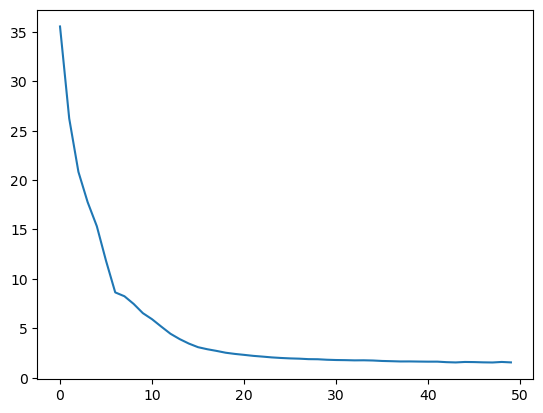

In [13]:
sgmodel = SkipGramNegativeSampling(n_nodes=len(G), dim=16)
epoch_loss = []
opt = Adam(sgmodel.parameters(), lr=0.1)
dloader = DataLoader(dataset, batch_size=len(G))
for epoch in trange(50):
    for start_nodes, pos_context, neg_context in dloader:
        loss = sgmodel(start_nodes, pos_context, neg_context).sum(dim=1).mean()
        opt.zero_grad()
        loss.backward()
        opt.step()
    epoch_loss.append(loss.item())
plt.plot(epoch_loss);

We evaluate the model by mutual information between ground truth labels and cluster indices.

In [14]:
with torch.no_grad():
    emb = sgmodel.start_node_emb(torch.arange(len(G)))
_, pred_labels, _ = k_means(emb, n_clusters=8)
mi = mutual_info_score(labels, pred_labels)
assert mi > 0.15

Let us plot the t-SNE visualization of node embeddings.

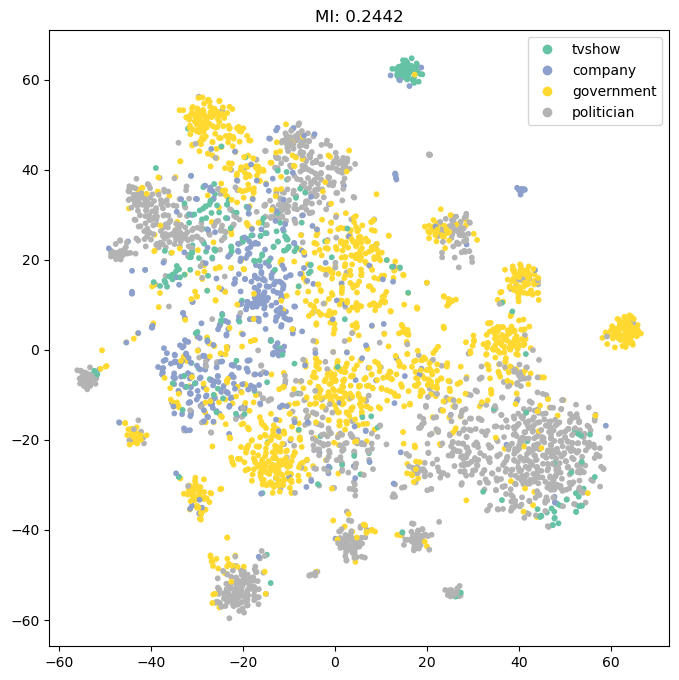

In [15]:
decomposition = TSNE(n_components=2)
xy_emb = decomposition.fit_transform(emb)

plt.figure(figsize=(8, 8))
scatter = plt.scatter(xy_emb[:, 0], xy_emb[:, 1], c=labels, s=10, cmap=plt.cm.Set2)

plt.legend(handles=scatter.legend_elements()[0], labels=unique)
plt.title(f'MI: {mi:.4f}');

### Task 2. Node2Vec (5 points)

In this task, we will consider Node2Vec embedding algorithm. In Node2Vec, we learn a mapping of nodes to a low-dimensional space of features that maximizes the likelihood of preserving network neighborhoods of nodes. It is similar to DeepWalk, but uses *biased random walk procedure* which efficiently explores diverse neighborhoods. There are two parameters:

* Return parameter $p$ controls the likelihood of immediately revisiting a node in the walk. Setting it to a high value ensures that we are less likely to sample an already-visited node in the following two steps.

* In-out parameter $q$ allows the search to differentiate between “inward” and “outward” nodes. If $q > 1$, the random walk is biased towards nodes close to previous node. In contrast, if $q < 1$, the walk is more inclined to visit nodes which are further away from the previous node.

<img src='https://raw.githubusercontent.com/netspractice/network-science/main/images/biased_random_walk.png' width=300>

Consider that we just moved from the node $t$ to $v$ and now we want to decide on the next step so it evaluates the transition probabilities on edges ($v$, $x$) leading from $v$. Then the *unnormalized* probability is

$$\alpha = \begin{cases}
\frac{1}{p} &  \text{ if } d_{tx} = 0\\
1 & \text{ if } d_{tx} = 1\\
\frac{1}{q} & \text{ if } d_{tx} = 2\\
\end{cases}$$

where $d_{tx}$ is the shortest path distance between nodes $t$ and $x$. To compute the true probability, we need to normalize values so that the sum is 1.

Write a function `biased_random_walk` that takes a graph, node for which we start random walk, length of walk, parameters `p` and `q` and returns a list with random walks.

*Hint: do not use `nx.shortest_path` to calcule shortest paths, it is too expensive. Look at the image above — we can explicitly calculate probabilities for all neighbors of $v$ using neighborhood of $t$*.

In [16]:
def biased_random_walk(G, node, length, p, q):
    walk = [node]
    while len(walk) < length:
        cur = walk[-1]
        if len(walk) == 1:
            neighbors = list(G.neighbors(cur))
        else:
            prev = walk[-2]
            neighbors = []
            for neighbor in G.neighbors(cur):
                if neighbor == prev:
                    p_ = 1 / p
                elif G.has_edge(neighbor, prev):
                    p_ = 1
                else:
                    p_ = 1 / q
                neighbors += [neighbor] * int(p_)
        walk.append(np.random.choice(neighbors))
    return walk

In [17]:
rwalks = biased_random_walk(G, 0, 10, 0.1, 0.5)
assert len(rwalks) == 10
rwalks = biased_random_walk(G, node=0, length=4, p=0.001, q=1000)
assert rwalks[0] == rwalks[2]
assert rwalks[1] == rwalks[3]
rwalks = biased_random_walk(G, node=0, length=4, p=1000, q=0.001)
assert len(set(rwalks)) >= 3

Let us generate biased random walks.

In [18]:
def sample_biased_random_walks(G, walks_per_node, length, p, q):
    walks = []
    for node in tqdm(G.nodes, leave=False, desc='Sampling biased random walks'):
        for _ in range(walks_per_node):
            walk_from_node = biased_random_walk(G, node, length, p, q)
            walks.append(walk_from_node)
    return np.array(walks)

In [19]:
walks_per_node = 5
length = 5
rwalks = sample_biased_random_walks(G, walks_per_node, length, p=0.25, q=0.25)
rwalks

Sampling biased random walks:   0%|          | 0/3873 [00:00<?, ?it/s]

array([[   0,   11,   65,  157, 1934],
       [   0,   31,   90,  340,  480],
       [   0,   11,   57,  167,   57],
       ...,
       [3872, 1980, 1861,  739, 2103],
       [3872, 1495,  529,  353,  529],
       [3872, 1495, 2121,  409, 2121]])

Train the model.

  0%|          | 0/50 [00:00<?, ?it/s]

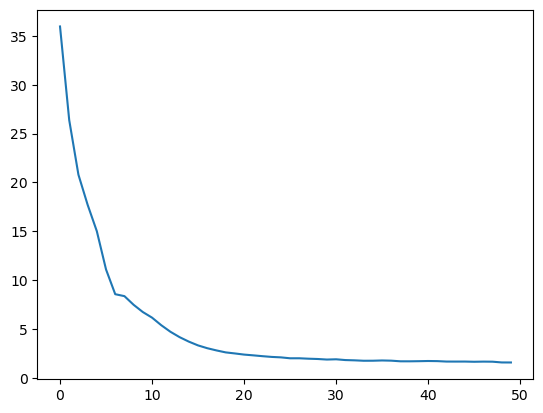

In [20]:
e_loss = []
dataset = NodeContextDataset(rwalks, len(G), n_neg=5)
dloader = DataLoader(dataset, batch_size=len(G))
sgmodel = SkipGramNegativeSampling(n_nodes=len(G), dim=16)
opt = Adam(sgmodel.parameters(), lr=0.1)
for e in trange(50):
    for start_nodes, pos_context, neg_context in dloader:
        loss = sgmodel(start_nodes, pos_context, neg_context).sum(dim=1).mean()
        opt.zero_grad()
        loss.backward()
        opt.step()
    e_loss.append(loss.item())
plt.plot(e_loss);

In [21]:
with torch.no_grad():
    emb = sgmodel.start_node_emb(torch.arange(len(G)))
_, pred_labels, _ = k_means(emb, n_clusters=8)
mi = mutual_info_score(labels, pred_labels)
assert mi > 0.15

Find the best $p$ and $q$. Write a function `grid_search_pq` that takes a graph, node labels and returns the best $p$ and $q$ by grid search in $\{0.01, 0.2, 1, 2, 8\}$. Sample biased random walks with 5 walks per node and the length 5. Evaluate the model by mutual information score between ground truth labels and k-means with 8 clusters. To pass time limits, calculate the best `p` and `q` and then rewrite the function as

```python
def grid_search_pq(graph):
    return best_p, best_q
    # your grid search implementation ...
```

In [25]:
# Find the best $p$ and $q$. Write a function `grid_search_pq` that takes a graph, node labels and returns the best $p$ and $q$ by grid search in $\{0.01, 0.2, 1, 2, 8\}$. Sample biased random walks with 5 walks per node and the length 5. Evaluate the model by mutual information score between ground truth labels and k-means with 8 clusters. To pass time limits, calculate the best `p` and `q` and then rewrite the function as


# def grid_search_pq(graph):
#     return best_p, best_q
#     # your grid search implementation ...

def grid_search_pq(graph, labels):
    best_mi = 0
    best_p = 0
    best_q = 0
    for p in [0.01, 0.2, 1, 2, 8]:
        for q in [0.01, 0.2, 1, 2, 8]:
            rwalks = sample_biased_random_walks(graph, 5, 5, p, q)
            dataset = NodeContextDataset(rwalks, len(graph), n_neg=5)
            dloader = DataLoader(dataset, batch_size=len(graph))
            sgmodel = SkipGramNegativeSampling(n_nodes=len(graph), dim=16)
            opt = Adam(sgmodel.parameters(), lr=0.1)
            for e in trange(50):
                for start_nodes, pos_context, neg_context in dloader:
                    loss = sgmodel(start_nodes, pos_context, neg_context).sum(dim=1).mean()
                    opt.zero_grad()
                    loss.backward()
                    opt.step()
            with torch.no_grad():
                emb = sgmodel.start_node_emb(torch.arange(len(graph)))
            _, pred_labels, _ = k_means(emb, n_clusters=8)
            mi = mutual_info_score(labels, pred_labels)
            if mi > best_mi:
                best_mi = mi
                best_p = p
                best_q = q
    return best_p, best_q

In [26]:
best_p, best_q = grid_search_pq(G, labels)
rwalks = sample_biased_random_walks(G, 5, 5, best_p, best_q)
dataset = NodeContextDataset(rwalks, len(G), n_neg=5)
dloader = DataLoader(dataset, batch_size=len(G))
sgmodel = SkipGramNegativeSampling(n_nodes=len(G), dim=16)
opt = Adam(sgmodel.parameters(), lr=0.1)
dloader = DataLoader(dataset, batch_size=len(G))
for epoch in trange(50):
    for start_nodes, pos_context, neg_context in dloader:
        loss = sgmodel(start_nodes, pos_context, neg_context).sum(dim=1).mean()
        opt.zero_grad()
        loss.backward()
        opt.step()
with torch.no_grad():
    emb = sgmodel.start_node_emb(torch.arange(len(G)))
_, pred_labels, _ = k_means(emb, n_clusters=8)
mi = mutual_info_score(labels, pred_labels)
assert mi > 0.21

Sampling biased random walks:   0%|          | 0/3873 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Sampling biased random walks:   0%|          | 0/3873 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Sampling biased random walks:   0%|          | 0/3873 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Sampling biased random walks:   0%|          | 0/3873 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Sampling biased random walks:   0%|          | 0/3873 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Sampling biased random walks:   0%|          | 0/3873 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Sampling biased random walks:   0%|          | 0/3873 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Sampling biased random walks:   0%|          | 0/3873 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Sampling biased random walks:   0%|          | 0/3873 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Sampling biased random walks:   0%|          | 0/3873 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Sampling biased random walks:   0%|          | 0/3873 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Sampling biased random walks:   0%|          | 0/3873 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Sampling biased random walks:   0%|          | 0/3873 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Sampling biased random walks:   0%|          | 0/3873 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Sampling biased random walks:   0%|          | 0/3873 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Sampling biased random walks:   0%|          | 0/3873 [00:00<?, ?it/s]

ValueError: 'a' cannot be empty unless no samples are taken

Plot t-SNE visualization of node embeddings.

In [ ]:
decomposition = TSNE(n_components=2)
xy_emb = decomposition.fit_transform(emb)

plt.figure(figsize=(8, 8))
scatter = plt.scatter(xy_emb[:, 0], xy_emb[:, 1], c=labels, s=10, cmap=plt.cm.Set2)

plt.legend(handles=scatter.legend_elements()[0], labels=unique)
plt.title(f'MI: {mi:.4f}');

NameError: name 'TSNE' is not defined

### Task 3. GraRep (5 points)

The idea behind GraRep is to account for multiscale relationships between nodes. For example,a student can have 1-hop neighborhood of friends, 2-hop neighborhood of classmates, 3-hop neighborhood of society and so on.

<img src="https://raw.githubusercontent.com/netspractice/network-science/main/images/multiscale_relationships.png" width=350>

Unlike DeepWalk, GraRep defines different objective functions for capturing the different $k$-step local relational information by manipulating transition matrices in the $k$-th powers defined over the graph. Recall that the transition matrix is $P = D^{-1}A$ where $D$ is a degree matrix. $P_{ij}$ refers to a probability to move from the node $i$ to the node $j$ in one step of a random walk. Therefore, $P^k_{ij}$ is a probability to move from the node $i$ to the node $j$ in $k$ steps of a random walk. 

Write a function `csr_transition_matrix` that takes a graph and returns a transition matrix. To save memory and speed up the following calculation of powers, convert transition matrix to sparse format by `scipy.sparse.csr_matrix`.

In [27]:
def csr_transition_matrix(G):
    A = nx.adjacency_matrix(G)
    A = A.todense()
    A = np.array(A, dtype=np.float64)
    D = np.diag(np.sum(A, axis=0))
    T = np.dot(np.linalg.inv(D), A)
    T = csr_matrix(T)
    return T

In [28]:
P = csr_transition_matrix(G)
assert type(P) == csr_matrix
assert P.shape == (len(G), len(G))
assert round(P[3, 9], 4) == 0.0417

Similar to DeepWalk, there are two types of embeddings:
* $v_i$ is a vector that represents the start node $i$
* $u_j$ is a vector that represents the context node $j$

Our objective aims to maximize: 1) the probability that these pairs come from the graph, and 2) the probability that all other pairs do not come from the graph (negative samples). The objective function for nodes $i, j$ in the transition matrix of the power $k$ is

$$\mathcal L^k_{ij} = P^k_{ij}\log \sigma(v_i^\top u_j) + \frac{\lambda}{|V|}\sum_{t=1}^{|V|}P^k_{tj}\log \sigma(-v_t^\top u_j)$$

where $\lambda$ is the hyperparameter indicating the number of negative samples. Optimizing this objective makes observed pairs $(i, j)$ have similar embeddings, while scattering unobserved pairs $(t, j)$. Substitution $v_i^\top u_j = X_{ij}$ and setting $\frac{\partial \mathcal L_{ij}}{ \partial X_{ij}} = 0$ yields

$$v_i^\top u_j = X_{ij}^k = \log \frac{P^k_{ij}}{\sum_{t=1}^{|V|}P^k_{tj}} - \log\frac{\lambda}{|V|}$$

Let us call $X^k$ log probabilistic matrix. Write a function `log_probabilistic_matrix` that takes a transition matrix, hyperparameter $\lambda$ and returns a log probabilistic matrix.

_Remark: to prevent $-\infty$ in log, add $\varepsilon=1^{-6}$ as follows `np.log(x + 1e-6)`_

In [29]:
def log_probabilistic_matrix(P, lambd):
    P = P.toarray()
    A = np.divide(P, P.sum(axis=0))
    B = np.divide(lambd, A.shape[0])
    return np.matrix(np.log(A + 1e-6) - np.log(B + 1e-6))

In [30]:
X = log_probabilistic_matrix(P, lambd=5)
assert type(X) == np.matrix
assert X.shape == (len(G), len(G))
assert round(X[3, 9], 4) == 3.182

The log probabilistic matrix $X^k$ can be approximated by truncated SVD so that

$$X^k \approx X_d^k = U_d^k \Sigma_d^k (V_d^k)^\top$$

where $d$ is the number of singular values of truncated SVD. Thus, embeddings of start nodes can be obtained by 

$$v_i = \left[U_d^k \sqrt{\Sigma_d^k}\right]_i$$ 

and embeddings of context nodes by 

$$u_j = \left[\sqrt{\Sigma_d^k} (V_d^k)^\top\right]_j$$ 

_Remark: the power 1/2 makes SVD symmetric. It is empirically shown that the symmetric SVD is better for social graphs and makes embeddings more "similar" to corresponding embeddings of SkipGram with negative sampling in a sence of some matrix properties._

Write a function `svd_emb` that takes a log probabilistic matrix, number of dimensions (number of largest singular values) in truncated SVD and returns embeddings of start nodes.

_Hint: use `scipy.sparse.linalg.svds` to calculate truncated SVD for a given number of singular values._

In [32]:
def svd_emb(X, dim):
    U, s, V = scipy.sparse.linalg.svds(X)
    return U[:, :dim]

In [33]:
_emb = svd_emb(X, dim=4)
assert type(_emb) == np.ndarray
assert _emb.shape == (3873, 4)


The resulting node embeddings are concatenated from the log probabilistic matrices $X, X^2, ..., X^k$.

In `grarep_emb`, we calculate powers of transition matrix $P, P^2, \dots, P^k$, calculate and concatenate embeddings of start nodes, then we compress them to the original number of dimensions by PCA.

In [34]:
def grarep_emb(G, dim, k, lambd):
    emb = []
    P_1 = csr_transition_matrix(G)
    P = P_1.copy()
    for i in trange(k):
        X = log_probabilistic_matrix(P, lambd=lambd)
        _emb = svd_emb(X, dim=dim)
        emb.append(_emb)
        if i == (k - 1):
            continue
        P = P @ P_1
    emb = PCA(n_components=dim).fit_transform(np.concatenate(emb, axis=1))
    return emb

Finally, we evaluate the model by mutual information between ground truth labels and cluster indices.

In [35]:
emb = grarep_emb(G, dim=16, k=4, lambd=5)
assert emb.shape == (len(G), 16)
_, pred_labels, _ = k_means(emb, n_clusters=8)
mi = mutual_info_score(labels, pred_labels)
assert mi > 0.22

  0%|          | 0/4 [00:00<?, ?it/s]

Plot t-SNE visualization of node embeddings.

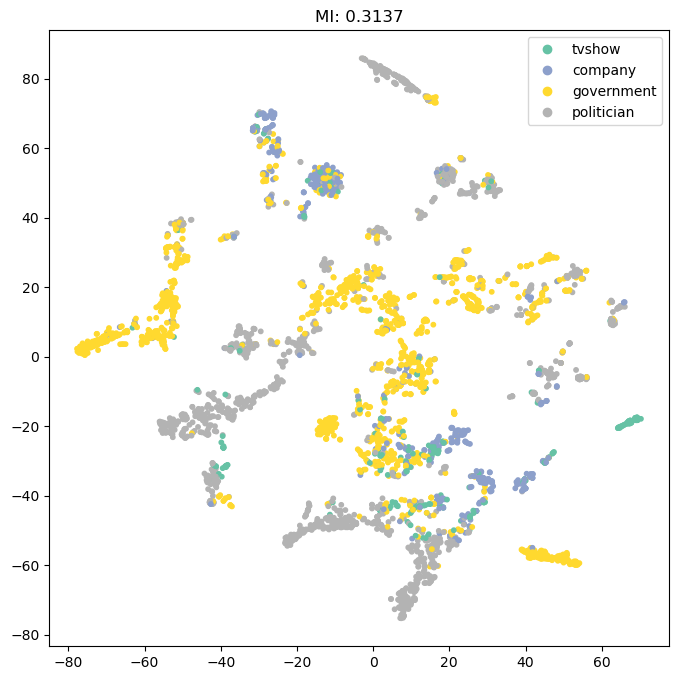

In [36]:
decomposition = TSNE(n_components=2)
xy_emb = decomposition.fit_transform(emb)

plt.figure(figsize=(8, 8))
scatter = plt.scatter(xy_emb[:, 0], xy_emb[:, 1], c=labels, s=10, cmap=plt.cm.Set2)
plt.legend(handles=scatter.legend_elements()[0], labels=unique)
plt.title(f'MI: {mi:.4f}');